# Régression Ridge, Lasso et nouvel estimateur

Ce notebook présente la régression Ridge, Lasso, et l'API de scikit-learn.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Un jeu de données pour un problème de régression

In [3]:
from sklearn.datasets import load_boston
data = load_boston()
X, y = data.data, data.target

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

On apprend la première régression linéaire.

In [5]:
from sklearn.linear_model import LinearRegression
lin = LinearRegression()
lin.fit(X_train, y_train)
lin.coef_

array([-8.69275318e-02,  4.48056842e-02,  6.24825218e-02,  2.28615393e+00,
       -1.76342061e+01,  3.60437303e+00,  7.04342241e-03, -1.33757857e+00,
        2.77131644e-01, -1.09183051e-02, -9.70016417e-01,  7.80847198e-03,
       -5.75938782e-01])

In [6]:
from sklearn.metrics import r2_score
r2_score(y_test, lin.predict(X_test))

0.7745986573246908

## Régression Ridge

La régression [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) optimise le problème qui suit :

$$\min_\beta E(\alpha, \beta) = \sum_{i=1}^n (y_i - X_i\beta)^2 + \alpha \lVert \beta \rVert ^2$$

C'est une régression linéaire avec une contrainte quadratique sur les coefficients. C'est utile lorsque les variables sont très corrélées, ce qui fausse souvent la résolution numérique. La solution peut s'exprimer de façon exacte.

$$\beta^* = (X'X + \alpha I)^{-1} X' Y$$

On voit qu'il est possible de choisir un $\alpha$ pour lequel la matrice $X'X + \alpha I$ est inversible. C'est aussi utile lorsqu'il y a beaucoup de variables, la probabilité d'avoir des variables corrélées est grande.

In [7]:
from sklearn.linear_model import Ridge
rid = Ridge(10).fit(X_train, y_train)
r2_score(y_test, rid.predict(X_test))

0.7571048536057976

In [8]:
(r2_score(y_train, lin.predict(X_train)), 
 r2_score(y_train, rid.predict(X_train)))

(0.7278033489983714, 0.7186162787689945)

La contrainte introduite sur les coefficients augmente l'erreur sur la base d'apprentissage et réduite la norme des coefficients.

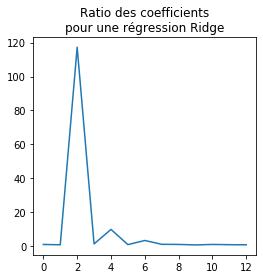

In [9]:
import numpy
import matplotlib.pyplot as plt
r = numpy.abs(lin.coef_) / numpy.abs(rid.coef_)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(r)
ax.set_title("Ratio des coefficients\npour une régression Ridge");

Un des coefficients est 10 fois plus grand et la norme des coefficients est plus petite.

In [10]:
numpy.linalg.norm(lin.coef_), numpy.linalg.norm(rid.coef_)

(18.230070813746508, 4.460202613814843)

De fait, il est préféreable de normaliser les variables avant d'appliquer la contrainte.

In [11]:
rid = Ridge(0.2, normalize=True).fit(X_train, y_train)
r2_score(y_test, rid.predict(X_test))

0.7485071049850724

In [12]:
numpy.linalg.norm(lin.coef_), numpy.linalg.norm(rid.coef_)

(18.230070813746508, 9.054910870876329)

## Régression Lasso

La régression [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) optimise le problème qui suit :

$$\min_\beta E(\alpha, \beta) = \sum_{i=1}^n (y_i - X_i\beta)^2 + \alpha \lVert \beta \rVert$$

C'est une régression linéaire avec une contrainte linéaire sur les coefficients. C'est utile lorsque les variables sont très corrélées, ce qui fausse souvent la résolution numérique. La solution ne s'exprime de façon exacte et la résolution utilise une méthode à base de gradient.

In [13]:
from sklearn.linear_model import Lasso
las = Lasso(5.).fit(X_train, y_train)
las.coef_

array([-0.        ,  0.03808832, -0.        ,  0.        ,  0.        ,
        0.        ,  0.04181527, -0.        ,  0.        , -0.00674656,
       -0.        ,  0.00349911, -0.80390873])

On voit que beaucoup de coefficients sont nuls.

In [14]:
las.coef_ == 0

array([ True, False,  True,  True,  True,  True, False,  True,  True,
       False,  True, False, False])

In [15]:
sum(las.coef_ == 0)

8

Comme pour la régression Ridge, il est préférable de normaliser. On étudie également le nombre de coefficients nuls en fonction de la valeur $\alpha$.

In [16]:
from tqdm import tqdm
res = []
for alf in tqdm([0.00001, 0.0001, 0.005, 0.01, 0.015, 
                 0.02, 0.025, 0.03, 0.04, 0.05, 0.06,
                 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4]):
    las = Lasso(alf, normalize=True).fit(X_train, y_train)
    r2 = r2_score(y_test, las.predict(X_test))
    res.append({'lambda': alf, 'r2': r2, 
                'nbnull': sum(las.coef_ == 0)})

    
from pandas import DataFrame
df = DataFrame(res)
df.head(5)

100%|██████████| 18/18 [00:00<00:00, 360.96it/s]


,lambda,r2,nbnull
0,0.00001,0.774585,0
1,0.00010,0.774459,0
2,0.00500,0.754867,2
3,0.01000,0.727994,4
4,0.01500,0.709553,5


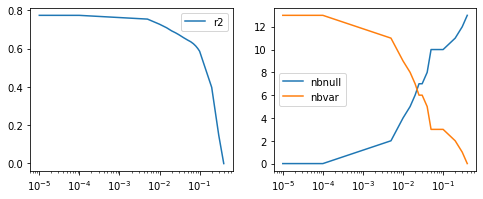

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].plot(df['lambda'], df['r2'], label='r2')
ax[1].plot(df['lambda'], df['nbnull'], label="nbnull")
ax[1].plot(df['lambda'], las.coef_.shape[0] - df['nbnull'], label="nbvar")
ax[0].set_xscale('log'); ax[1].set_xscale('log')
ax[0].legend(); ax[1].legend();

La régression Lasso annule les coefficients, voire tous les coefficients si le paramètre $\alpha$ est assez grand. Voyons cela pour une régression avec une seule variable. On doit minimiser l'expression :

$$E(\beta) = \sum_{i=1}^n (y_i - \beta x_i)^2 + \alpha |\beta|$$

Trouver $\beta^*$ qui minimise l'expression nécessite de trouver le paramètre $\beta$ tel que $E(\beta)=0$. On calcule la dérivée $E'(\beta)$ :

$$E'(\beta) = \left \{ \begin{array}{ll} \sum_{i=1}^n -x_i(y_i - \beta x_i) + \alpha & \text{si } \beta > 0 \\ \sum_{i=1}^n -x_i(y_i - \beta x_i) - \alpha & \text{si } \beta < 0 \end{array} \right .$$

Et :

$$E'(\beta) = 0 \Leftrightarrow \left \{ \begin{array}{ll} \beta = \frac{-\alpha + \sum_{i=1}^n x_i y_i}{\sum_{i=1}^n{x_i^2}} & \text{si } \beta > 0 \\ \beta = \frac{\alpha + \sum_{i=1}^n x_i y_i}{\sum_{i=1}^n{x_i^2}}  & \text{si } \beta < 0 \end{array} \right .$$

On voit que pour une grande valeur de $\alpha > \sum_i x_i y_i$, le paramètre $\beta$ n'a pas de solution. Dans le premier cas, la valeur est nécessairement négative alors que la solution ne fonctionne que si $\beta$ est positive. C'est la même situation contradictoire dans l'autre cas. La seule option possible lorsque $\alpha$ est très grand, c'est $\beta = 0$. On montre donc que ce qu'on a observé ci-dessus est vrai pour une régression à une dimension.

## Application à la sélection d'arbre d'une forêt aléatoire

Une forêt aléatoire est simplement une moyenne des prédictions d'arbres de régression.

$$RF(X) = \sum_{i=1}^p T_i(X)$$

Pourquoi ne pas utiliser une régression Lasso pour réduire le nombre d'arbres et exprimer la forêt aléatoire avec des coefficients $\beta$ estimés à l'aide d'une régression Lasso et choisis de telle sorte que beaucoup soient nuls.

$$RF(X) = \sum_{i=1}^p \beta_i T_i(X)$$

In [18]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(100).fit(X_train, y_train)

La prédiction d'un arbre s'obtient avec :

In [19]:
rf.estimators_[0].predict(X_test)

array([20.3, 10.2,  7.2, 30.8, 26.4, 19.5, 14.1, 14.1, 21.4, 11.7, 10.2,
       19.5, 18.3, 31.6, 18.2, 29.1, 19.5, 19.5, 29.1, 18.2, 26.5, 16.1,
       20. , 36.5, 14.3, 17.7, 26.5, 20.1,  7.2, 12.6, 20.8, 31.7, 15.2,
       21.4, 22.7, 46. ,  7.2, 18.7, 24.3, 16.8, 24.2, 21.7, 13.4, 20.3,
       19. , 20.8, 26.4, 14.3, 14.3, 23.2, 30.3, 24.1, 15.6, 24.5, 20.4,
       24.8, 23.9, 23.2, 28.5, 16.2, 19.2, 27.1,  7.2, 31.2, 17.8, 34.7,
       29.1, 20.1, 36.5, 24.5, 24.3,  7.2, 19.3, 16. , 10.2, 17.1, 21.7,
       24.3, 17.4, 22.8, 33.1,  7.2,  7. , 24.5, 15.6, 42.3,  7.2, 19.9,
       19.5, 31.5, 25.1,  6.3, 11.7, 33.2, 17.5, 20.3, 50. , 21.4, 13.3,
       16.2, 22.9, 13.3, 16.2, 31.2, 21.5, 22. , 25. ,  7. , 16.2, 37.3,
       10.2, 20. , 27.5, 18.5, 24.5, 25.1, 22. , 17.7, 24.6, 23.3, 18.5,
       18.4, 17.8, 23. , 32.5, 21.7, 25.1])

On construit une fonction qui concatène les prédictions des arbres.

In [20]:
def concatenate_prediction(X):
    preds = []
    for i in range(len(rf.estimators_)):
        pred = rf.estimators_[i].predict(X)
        preds.append(pred)
    return numpy.vstack(preds).T

concatenate_prediction(X_test).shape

(127, 100)

Et on observe la performance en fonction du paramètre $\alpha$ de la régression Lasso.

In [21]:
X_train_rf = concatenate_prediction(X_train)
X_test_rf = concatenate_prediction(X_test)

res = []
for alf in tqdm([0.0001, 0.01, 0.1, 0.2, 0.5, 1., 
                 1.2, 1.5, 2., 4., 6., 8., 10., 12.,
                 14, 16, 18, 20]):
    las = Lasso(alf, max_iter=40000).fit(X_train_rf, y_train)
    r2 = r2_score(y_test, las.predict(X_test_rf))
    r2_rf = r2_score(y_test, rf.predict(X_test))
    res.append({'lambda': alf, 'r2': r2, 'r2_rf': r2_rf,
                'nbnull': sum(las.coef_ == 0)})

  0%|          | 0/18 [00:00<?, ?it/s]C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 92.35477221170673, tolerance: 3.2650859472295526
  positive)
100%|██████████| 18/18 [00:09<00:00,  7.26it/s]


In [22]:
df = DataFrame(res)
df.head(3)

,lambda,r2,r2_rf,nbnull
0,0.0001,0.845234,0.838246,0
1,0.0100,0.846901,0.838246,9
2,0.1000,0.853946,0.838246,39


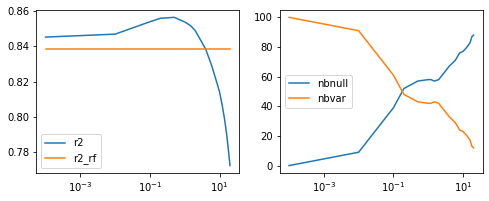

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].plot(df['lambda'], df['r2'], label='r2')
ax[0].plot(df['lambda'], df['r2_rf'], label='r2_rf')
ax[1].plot(df['lambda'], df['nbnull'], label="nbnull")
ax[1].plot(df['lambda'], las.coef_.shape[0] - df['nbnull'], label="nbvar")
ax[0].set_xscale('log'); ax[1].set_xscale('log')
ax[0].legend(); ax[1].legend();

## Validation croisée et API scikit-learn

La validation croisée est simple à faire dans *scikit-learn* est simple à faire si le modèle suit l'API de *scikit-learn* mais ce n'est pas le cas avec notre nouveau modèle. C'est pourtant essentiel pour s'assurer que le modèle est robuste. Toutefois *scikit-learn* permet de créer de nouveau modèle à la sauce *sciki-learn*.

In [24]:
from sklearn.base import BaseEstimator, RegressorMixin

class LassoRandomForestRegressor(BaseEstimator, RegressorMixin):
    def __init__(self,
                 # Lasso
                 alpha=1.0, fit_intercept=True, normalize=False,
                 precompute=False, copy_X=True, max_iter=1000,
                 tol=1e-4, warm_start_lasso=False, positive=False,
                 random_state=None, selection='cyclic',
                 # RF 
                 n_estimators=100,
                 criterion="mse",
                 max_depth=None,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 min_weight_fraction_leaf=0.,
                 max_features="auto",
                 max_leaf_nodes=None,
                 min_impurity_decrease=0.,
                 min_impurity_split=None,
                 bootstrap=True,
                 oob_score=False,
                 n_jobs=None,
                 # random_state=None,
                 verbose=0,
                 warm_start_rf=False,
                 ccp_alpha=0.0,
                 max_samples=None):

        # Lasso
        self.alpha = alpha
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.precompute = precompute
        self.copy_X = copy_X
        self.max_iter = max_iter
        self.tol = tol
        self.warm_start_lasso = warm_start_lasso
        self.positive = positive
        self.random_state = random_state
        self.selection = selection
        # RF 
        self.n_estimators = n_estimators
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_weight_fraction_leaf = min_weight_fraction_leaf
        self.max_features = max_features
        self.max_leaf_nodes = max_leaf_nodes
        self.min_impurity_decrease = min_impurity_decrease
        self.min_impurity_split = min_impurity_split
        self.bootstrap = bootstrap
        self.oob_score = oob_score
        self.n_jobs = n_jobs
        self.random_state = random_state
        self.verbose = verbose
        self.warm_start_rf = warm_start_rf
        self.ccp_alpha = ccp_alpha
        self.max_samples = max_samples

    def _concatenate_prediction(self, X):
        preds = []
        for i in range(len(self.rf_.estimators_)):
            pred = self.rf_.estimators_[i].predict(X)
            preds.append(pred)
        return numpy.vstack(preds).T        
        
    def fit(self, X, y, sample_weight=None):
        self.rf_ = RandomForestRegressor(
            n_estimators=self.n_estimators, criterion=self.criterion,
            max_depth=self.max_depth, min_samples_split=self.min_samples_split,
            min_samples_leaf=self.min_samples_leaf,
            min_weight_fraction_leaf=self.min_weight_fraction_leaf,
            max_features=self.max_features, max_leaf_nodes=self.max_leaf_nodes,
            min_impurity_decrease=self.min_impurity_decrease,
            min_impurity_split=self.min_impurity_split, bootstrap=self.bootstrap,
            oob_score=self.oob_score, n_jobs=self.n_jobs,
            random_state=self.random_state, verbose=self.verbose,
            warm_start=self.warm_start_rf, ccp_alpha=self.ccp_alpha,
            max_samples=self.max_samples)
        
        self.rf_.fit(X, y, sample_weight=sample_weight)
        X_rf = self._concatenate_prediction(X)
        
        self.lasso_ = Lasso(
            alpha=self.alpha, max_iter=self.max_iter, fit_intercept=self.fit_intercept,
            normalize=self.normalize, precompute=self.precompute, copy_X=self.copy_X,
            tol=self.tol, warm_start=self.warm_start_lasso, positive=self.positive,
            random_state=self.random_state, selection=self.selection)
        
        self.lasso_.fit(X_rf, y)
        return self
    
    def predict(self, X):
        X_rf = self._concatenate_prediction(X)
        return self.lasso_.predict(X_rf)


model = LassoRandomForestRegressor(
            alpha=1, n_estimators=100, max_iter=10000)
model.fit(X_train, y_train)
pred = model.predict(X_test)
r2_score(y_test, pred)

0.8346874821795568

Et la validation croisée  fut :

In [25]:
from sklearn.model_selection import cross_val_score
cross_val_score(model, X_train, y_train, cv=5)

array([0.910021  , 0.84029193, 0.8580938 , 0.8625352 , 0.91038903])

Ce n'est pas très robuste. Peut-être est-ce dû à l'ordre des données (un léger effet temporel).

In [26]:
from sklearn.model_selection import ShuffleSplit
cross_val_score(LassoRandomForestRegressor(
                    n_estimators=100, alpha=10, max_iter=10000),
                X_train, y_train, cv=ShuffleSplit(5))

array([0.89211504, 0.84095761, 0.90532544, 0.83635709, 0.91267968])

Pas beaucoup mieux. Le modèle n'est pas très robuste.

On essaye néanmoins de trouver les meilleurs paramètres à l'aide d'une grille de recherche.

In [27]:
from sklearn.model_selection import GridSearchCV
params = {'alpha': [0.1, 0.5, 1., 2., 5., 10],
          'n_estimators': [10, 20, 50, 100],
          'max_iter': [10000]
         }
grid = GridSearchCV(LassoRandomForestRegressor(),
                    param_grid=params, verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.166205074990216, tolerance: 2.7719733552631576
  positive)
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   33.7s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=LassoRandomForestRegressor(alpha=1.0, bootstrap=True,
                                                  ccp_alpha=0.0, copy_X=True,
                                                  criterion='mse',
                                                  fit_intercept=True,
                                                  max_depth=None,
                                                  max_features='auto',
                                                  max_iter=1000,
                                                  max_leaf_nodes=None,
                                                  max_samples=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                   

In [28]:
grid.best_params_

{'alpha': 0.1, 'max_iter': 10000, 'n_estimators': 100}

In [29]:
r2_score(y_test, grid.best_estimator_.predict(X_test))

0.8318986652772324

In [30]:
sum(grid.best_estimator_.lasso_.coef_ == 0)

39

On a réussi à supprimer 27 arbres.

## Optimisation mémoire

Le modèle précédent n'est pas optimal dans le sens où il stocke en mémoire tous les arbres, mêmes ceux associés à un coefficient nuls après la régression Lasso alors que le calcul ne sert à rien puisque ignoré.

In [31]:
class OptimizedLassoRandomForestRegressor(BaseEstimator, RegressorMixin):
    def __init__(self,
                 # Lasso
                 alpha=1.0, fit_intercept=True, normalize=False,
                 precompute=False, copy_X=True, max_iter=1000,
                 tol=1e-4, warm_start_lasso=False, positive=False,
                 random_state=None, selection='cyclic',
                 # RF 
                 n_estimators=100,
                 criterion="mse",
                 max_depth=None,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 min_weight_fraction_leaf=0.,
                 max_features="auto",
                 max_leaf_nodes=None,
                 min_impurity_decrease=0.,
                 min_impurity_split=None,
                 bootstrap=True,
                 oob_score=False,
                 n_jobs=None,
                 # random_state=None,
                 verbose=0,
                 warm_start_rf=False,
                 ccp_alpha=0.0,
                 max_samples=None):
        
        # Lasso
        self.alpha = alpha
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.precompute = precompute
        self.copy_X = copy_X
        self.max_iter = max_iter
        self.tol = tol
        self.warm_start_lasso = warm_start_lasso
        self.positive = positive
        self.random_state = random_state
        self.selection = selection
        # RF 
        self.n_estimators = n_estimators
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_weight_fraction_leaf = min_weight_fraction_leaf
        self.max_features = max_features
        self.max_leaf_nodes = max_leaf_nodes
        self.min_impurity_decrease = min_impurity_decrease
        self.min_impurity_split = min_impurity_split
        self.bootstrap = bootstrap
        self.oob_score = oob_score
        self.n_jobs = n_jobs
        self.random_state = random_state
        self.verbose = verbose
        self.warm_start_rf = warm_start_rf
        self.ccp_alpha = ccp_alpha
        self.max_samples = max_samples

    def _concatenate_prediction(self, X):
        preds = []
        for i in range(len(self.rf_.estimators_)):
            pred = self.rf_.estimators_[i].predict(X)
            preds.append(pred)
        return numpy.vstack(preds).T        
        
    def fit(self, X, y, sample_weight=None):
        
        self.rf_ = RandomForestRegressor(
            n_estimators=self.n_estimators, criterion=self.criterion,
            max_depth=self.max_depth, min_samples_split=self.min_samples_split,
            min_samples_leaf=self.min_samples_leaf,
            min_weight_fraction_leaf=self.min_weight_fraction_leaf,
            max_features=self.max_features, max_leaf_nodes=self.max_leaf_nodes,
            min_impurity_decrease=self.min_impurity_decrease,
            min_impurity_split=self.min_impurity_split, bootstrap=self.bootstrap,
            oob_score=self.oob_score, n_jobs=self.n_jobs,
            random_state=self.random_state, verbose=self.verbose,
            warm_start=self.warm_start_rf, ccp_alpha=self.ccp_alpha,
            max_samples=self.max_samples)
        
        self.rf_.fit(X, y, sample_weight=sample_weight)
        X_rf = self._concatenate_prediction(X)
        
        self.lasso_ = Lasso(
            alpha=self.alpha, max_iter=self.max_iter, fit_intercept=self.fit_intercept,
            normalize=self.normalize, precompute=self.precompute, copy_X=self.copy_X,
            tol=self.tol, warm_start=self.warm_start_lasso, positive=self.positive,
            random_state=self.random_state, selection=self.selection)
        
        self.lasso_.fit(X_rf, y)
        
        # on ne garde que les arbres associées à des coefficients non nuls
        self.coef_ = []
        self.intercept_ = self.lasso_.intercept_
        self.estimators_ = []
        for i in range(len(self.rf_.estimators_)):
            if self.lasso_.coef_[i] != 0:
                self.estimators_.append(self.rf_.estimators_[i])
                self.coef_.append(self.lasso_.coef_[i])
        
        self.coef_ = numpy.array(self.coef_)
        del self.lasso_
        del self.rf_        
        return self
    
    def predict(self, X):
        preds = []
        for i in range(len(self.estimators_)):
            pred = self.estimators_[i].predict(X)
            preds.append(pred)
        x_rf = numpy.vstack(preds).T 
    
        return x_rf @ self.coef_ + self.intercept_

model2 = OptimizedLassoRandomForestRegressor()
model2.fit(X_train, y_train)
pred = model2.predict(X_test)
r2_score(y_test, pred)

C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.42391563443033, tolerance: 3.2650859472295526
  positive)


0.8507578182842032

Le modèle produit bien les mêmes résultats. Vérifions que le nouveau modèle prend moins de place une fois enregistré sur le disque.

In [32]:
import pickle

with open("optimzed_rf.pickle", "wb") as f:
    pickle.dump(model2, f)

In [33]:
with open("optimzed_rf.pickle", "rb") as f:
    model2 = pickle.load(f)

r2_score(y_test, model2.predict(X_test))

0.8507578182842032

In [34]:
with open("lasso_rf.pickle", "wb") as f:
    pickle.dump(model, f)

In [35]:
import os
os.stat("optimzed_rf.pickle").st_size, os.stat("lasso_rf.pickle").st_size

(1104550, 2942584)

C'est bien le cas.